In [103]:
import os, shutil
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage
import pickle
import matplotlib.image as mpimg
from lxml import etree
from tqdm import tqdm
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import tensorflow as tf
from mrcnn import utils
import matplotlib.patheffects as path_effects

In [2]:
food_labels = ['HotMain',
               'GreenVeg', 
               'OrangeVeg',
               'Starch',
               'Bread',
               'Dessert',
               'Sandwich',
               'SaladBowl',
               'Juice',
               'FreshFruit',
               'MilkDrink',
               'Soup']
class_labels = ['HotMain',
               'GreenVeg', 
               'OrangeVeg',
               'Starch',
               'Bread',
               'Dessert',
               'Sandwich',
               'SaladBowl',
               'Juice',
               'FreshFruit',
               'MilkDrink',
               'Soup',
               'Tray',
               'Plate']
class_map = {x:i+1 for i,x in enumerate(class_labels)} 

In [3]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn import visualize

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [5]:
class FoodConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "healthhack"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 14  # background + 3 foods

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.8
    
config_train = FoodConfig()

In [6]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config_train.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                27
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [7]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [100]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return fig,ax

In [9]:
class foodDataset(utils.Dataset):
    def load_food(self, dataset_dir, subset):
        self.add_class("healthhack",1,"HotMain")
        self.add_class("healthhack",2,"GreenVeg")
        self.add_class("healthhack",3,"OrangeVeg")
        self.add_class("healthhack",4,"Starch")
        self.add_class("healthhack",5,"Bread")
        self.add_class("healthhack",6,"Dessert")
        self.add_class("healthhack",7,"Sandwich")
        self.add_class("healthhack",8,"SaladBowl")
        self.add_class("healthhack",9,"Juice")
        self.add_class("healthhack",10,"FreshFruit")
        self.add_class("healthhack",11,"MilkDrink")
        self.add_class("healthhack",12,"Soup")
        self.add_class("healthhack",13,"Tray")
        self.add_class("healthhack",14,"Plate")
        
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        with open(os.path.join(dataset_dir, 'annotations.pkl'), 'rb') as f:
            annotations = pickle.load(f)
            
        for a in annotations:
            shapes = a["shapes"]
            image_path = os.path.join(dataset_dir,'imgs', a['name'])
            image = skimage.io.imread(image_path)
            height = a["height"]
            width = a["width"]
            
            self.add_image(
                "healthhack",
                image_id = a["id"],
                path = image_path,
                width = width,
                height = height,
                shapes = shapes
            )
        
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        if info["source"] != "healthhack":
            return super(self.__class__, self).load_mask(image_id)
        
        shape_points = []
        shape_labels = []
        
        shapes = info["shapes"]
        for shape in shapes:
            if (shape['type']=='box') & (shape['label']=='Tray'):
                shape_points.append(shape['points'].T)
                shape_labels.append(shape['label'])
        for shape in shapes:
            if (shape['type']=='polygon') & (shape['label']=='Plate'):
                shape_points.append(shape['points'].T)
                shape_labels.append(shape['label'])
        for shape in shapes:
            if (shape['type']=='polygon') & (shape['label'] in food_labels):
                    shape_points.append(shape['points'].T)
                    shape_labels.append(shape['label'])

        n_instances = len(shape_labels)

        mask = np.zeros([info["height"], info["width"], n_instances],
                        dtype=np.uint8)

        for i,p in enumerate(shape_points):
            rr, cc = skimage.draw.polygon(p[1], p[0])
            mask[rr, cc, i] = 1

        # Handle occlusions. This just decides that the most recent shape is the topmost.
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(n_instances-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))

        class_ids = np.array([class_map[label] for label in shape_labels])
        
        return mask.astype(np.bool), class_ids.astype(np.int32)
    
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "healthhack":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [10]:
dataset_dir = './prepared_data/'

In [11]:
# Validation dataset
dataset_val = foodDataset()
dataset_val.load_food(dataset_dir, "val")
dataset_val.prepare()

In [12]:
print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

Images: 59
Classes: ['BG', 'HotMain', 'GreenVeg', 'OrangeVeg', 'Starch', 'Bread', 'Dessert', 'Sandwich', 'SaladBowl', 'Juice', 'FreshFruit', 'MilkDrink', 'Soup', 'Tray', 'Plate']


In [13]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

W0922 12:17:37.454363 139915476776704 deprecation_wrapper.py:119] From /home/mahasen/anaconda3/envs/mrcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0922 12:17:37.459047 139915476776704 deprecation_wrapper.py:119] From /home/mahasen/anaconda3/envs/mrcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0922 12:17:37.462610 139915476776704 deprecation_wrapper.py:119] From /home/mahasen/anaconda3/envs/mrcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0922 12:17:37.485649 139915476776704 deprecation_wrapper.py:119] From /home/mahasen/anaconda3/envs/mrcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is d

In [14]:
model.find_last()

'/home/mahasen/healthhack2019/Mask_RCNN/logs/healthhack20190922T0713/mask_rcnn_healthhack_0054.h5'

In [15]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = '/home/mahasen/healthhack2019/Mask_RCNN/logs/healthhack20190922T0713/mask_rcnn_healthhack_0045.h5'

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/mahasen/healthhack2019/Mask_RCNN/logs/healthhack20190922T0713/mask_rcnn_healthhack_0045.h5
Re-starting from epoch 45


In [30]:
len(class_labels)


14

In [93]:
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels)+1)]
colors.reverse()

In [94]:
colors

[(0.6196078431372549, 0.8549019607843137, 0.8980392156862745, 1.0),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883, 1.0),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451, 1.0),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451, 1.0),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 (1.0, 0.596078431372549, 0.5882352941176471, 1.0),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)]

In [81]:
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

In [82]:
from skimage.measure import find_contours

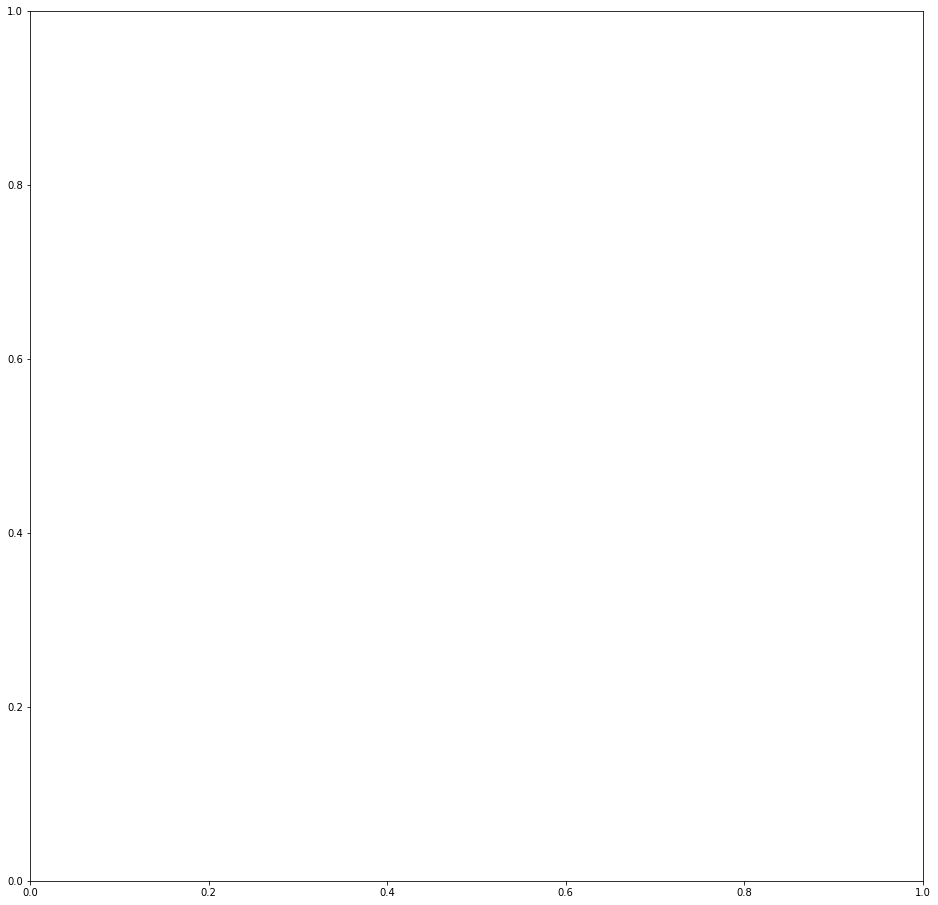

In [110]:
ax = get_ax()

In [125]:
def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
#     ax.set_ylim(height + 10, -10)
#     ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    h = []
    for i in range(N):
        color = colors[class_ids[i]]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
            
        else:
            caption = captions[i]
        h.append(ax.text(x1, y1 + 8, caption,
                color=color, size=26, backgroundcolor="none"))
        h[-1].set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])
        

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()


image ID: healthhack.474 (40) ./prepared_data/val/imgs/hh_4comp_475_ud.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 27)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (7,)                  min:    1.00000  max:   14.00000  int32
gt_bbox                  shape: (7, 4)                min:  321.00000  max: 1024.00000  int32
gt_mask                  shape: (1024, 1024, 7)       min:    0.00000  max:    1.00000  bool


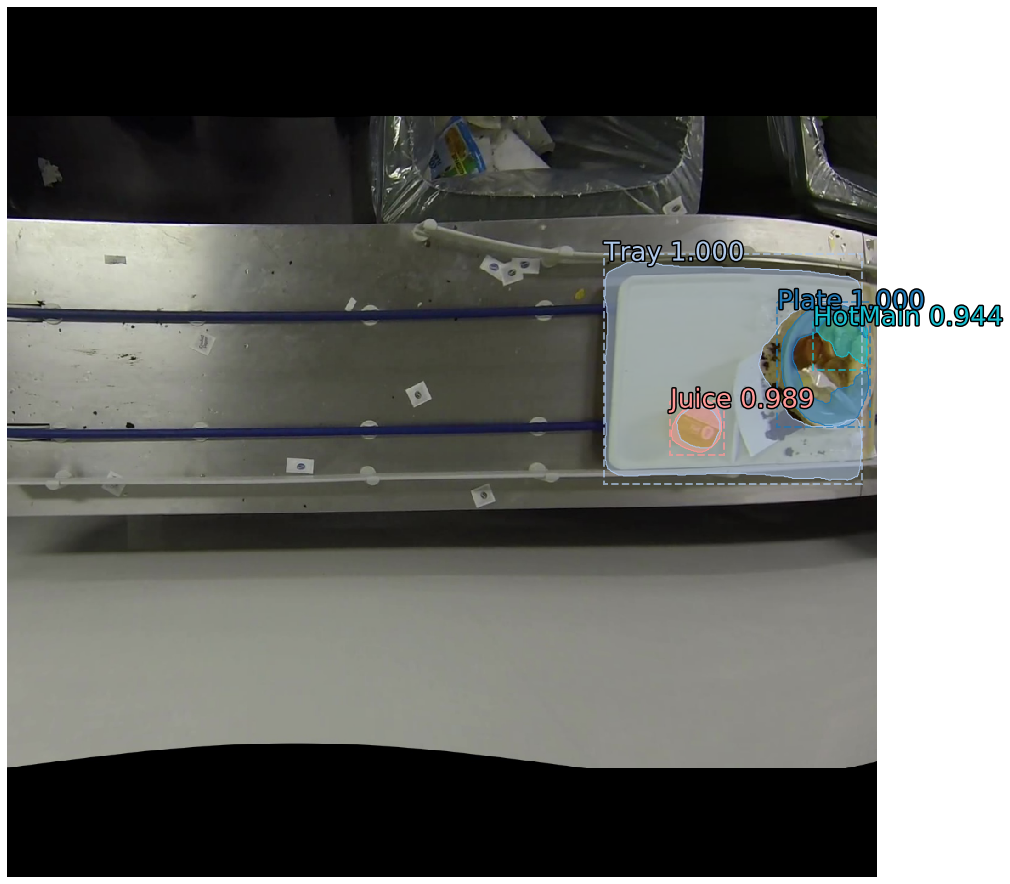

In [126]:
image_id = random.choice(dataset_val.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
fig, ax = get_ax(1)
r = results[0]
display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="", colors=colors)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Postprocessing code
- Construct hierarchy: associate centroids of detected things first to parent plates, then to parent tray

In [127]:
tray_id = class_map['Tray']
plate_id = class_map['Plate']

# Export predictions of validation set

In [128]:
results_list = []
for ind in dataset_val.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, ind, use_mini_mask=False)
    
    info = dataset_val.image_info[ind]
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], ind, 
                                           dataset_val.image_reference(ind)))
    
    # Run object detection
    results = model.detect([image], verbose=1);
    results_list.append(results[0]);
    

image ID: healthhack.426 (0) ./prepared_data/val/imgs/hh_4comp_427_ud.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 27)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
image ID: healthhack.427 (1) ./prepared_data/val/imgs/hh_4comp_428_ud.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 27)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
image ID: healthhack.428 (2) ./prepared_data/val/img

KeyboardInterrupt: 

# Creating COCO JSON

In [124]:
det_ind = 0
det_list = []
for image_id, result in enumerate(results_list):
    for inst_id, inst in enumerate(result['class_ids']):
        mask = result['masks'][:,:,inst_id]
        
        # Detect contours from binary mask, then take first contour
        image, contours, hierarchy = cv2.findContours(mask.astype(np.uint8) ,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        contour = contours[0].flatten('C')
        
        d = {'segmentation': [contour.tolist()],
             'iscrowd': 0,
             'image_id': int(image_id),
             'category_id': int(result['class_ids'][inst_id]), 
             'id': int(det_ind), 
             'bbox': result['rois'][inst_id].tolist(),
             'area': int(np.sum((mask==True).astype(np.int)))}
        
        det_ind +=1
        det_list.append(d)
    

In [132]:
with open('./coco_json/annotations.json', 'w') as f:
    json.dump(det_list, f)

In [133]:
cat_list = [{"id": val, "name": key, "supercategory": "None"} for key,val in class_map.items()]

In [135]:
with open('./coco_json/categories.json', 'w') as f:
    json.dump(cat_list, f)

In [143]:
# Let's also move the images
#12
for ind in dataset_val.image_ids:    
    info = dataset_val.image_info[ind]
    shutil.copy(dataset_val.image_reference(ind), os.path.join('./coco_json/imgs/%012d.jpg'%ind))
    

In [144]:
pwd

'/home/mahasen/healthhack2019/Mask_RCNN/samples/heha'

In [ ]:
image_id = random.choice(dataset_val.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Make video

In [17]:
pwd

'/home/mahasen/healthhack2019/Mask_RCNN/samples/heha'

In [129]:
video_img_path = './excerpt/eximg_ud/'
video_img_path_out = './excerpt/eximg_ud_inf/'

files  = os.listdir(video_img_path)

In [ ]:

for i, file in tqdm(enumerate(files)):
    image = skimage.io.imread(os.path.join(video_img_path, file))
    
    results = model.detect([image], verbose=1)
    r = results[0]
    fig, ax = get_ax(1)
    display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="", colors=colors)
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(os.path.join(video_img_path_out, file), bbox_inches=extent)

In [ ]:
image_id = random.choice(dataset_val.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results

r = results[0]

log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)